In [37]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [38]:
classes = ['Cat', 'Dog']
original_cat_path = 'C:/Users/GTata/Downloads/PetImages/Cat'
original_dog_path = 'C:/Users/GTata/Downloads/PetImages/Dog'
random.seed(101)

In [39]:
cat_files = os.listdir(original_cat_path)
dog_files = os.listdir(original_dog_path)

random.shuffle(cat_files)
random.shuffle(dog_files)

In [40]:
size = min(len(cat_files), len(dog_files))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

base_directory = 'dataset'
os.mkdir(base_directory)

type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(cat_files, dog_files):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

Dog - train: 8751	Cat - train: 8751
Dog - valid: 2500	Cat - valid: 2500
Dog - test:  1249	Cat - test:  1249


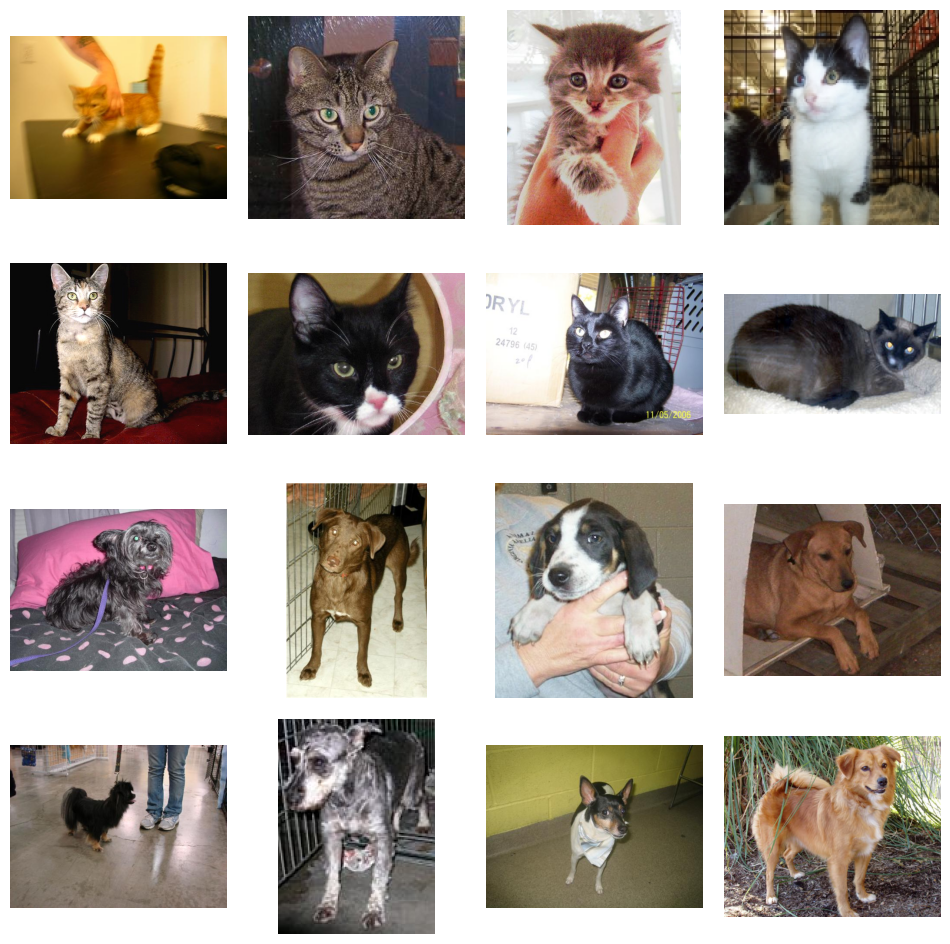

In [41]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [42]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17501 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.
Found 17501 images belonging to 2 classes.


In [43]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [44]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1)                 67501     
                                                                 
Total params: 67501 (263.68 KB)
Trainable params: 67501 (263.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [46]:
history_baseline = model_baseline.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.5084

C:\Users\GTata\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 96s 699ms/step - loss: 0.9896 - accuracy: 0.5084 - val_loss: 0.9285 - val_accuracy: 0.4896
Epoch 2/1000
136/136 [==============================] - 70s 513ms/step - loss: 0.9391 - accuracy: 0.5106 - val_loss: 1.0122 - val_accuracy: 0.4972
Epoch 3/1000
136/136 [==============================] - 51s 374ms/step - loss: 0.9365 - accuracy: 0.5110 - val_loss: 0.7592 - val_accuracy: 0.5196
Epoch 4/1000
136/136 [==============================] - 39s 288ms/step - loss: 0.9167 - accuracy: 0.5221 - val_loss: 0.8385 - val_accuracy: 0.5244
Epoch 5/1000
136/136 [==============================] - 32s 237ms/step - loss: 0.9200 - accuracy: 0.5307 - val_loss: 0.9200 - val_accuracy: 0.5012
Epoch 6/1000
136/136 [==============================] - 28s 207ms/step - loss: 0.9053 - accuracy: 0.5358 - val_loss: 0.7924 - val_accuracy: 0.5272
Epoch 7/1000
136/136 [==============================] - 26s 194ms/step - loss: 0.9143 - accuracy: 0.5329 - val_loss: 0.7183 - val_a

### Model Simple 1

In [47]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 10)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 54760)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 54761     
                                                                 
Total params: 55041 (215.00 KB)
Trainable params: 55041 (215.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
history_simple_1 = model_simple_1.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 43s 311ms/step - loss: 0.7567 - accuracy: 0.5832 - val_loss: 0.6208 - val_accuracy: 0.6526
Epoch 2/1000
136/136 [==============================] - 39s 287ms/step - loss: 0.5803 - accuracy: 0.6919 - val_loss: 0.6029 - val_accuracy: 0.6919
Epoch 3/1000
136/136 [==============================] - 40s 297ms/step - loss: 0.5494 - accuracy: 0.7253 - val_loss: 0.5929 - val_accuracy: 0.6731
Epoch 4/1000
136/136 [==============================] - 40s 292ms/step - loss: 0.5092 - accuracy: 0.7542 - val_loss: 0.5793 - val_accuracy: 0.6975
Epoch 5/1000
136/136 [==============================] - 38s 281ms/step - loss: 0.4921 - accuracy: 0.7691 - val_loss: 0.5794 - val_accuracy: 0.7071
Epoch 6/1000
136/136 [==============================] - 37s 275ms/step - loss: 0.4593 - accuracy: 0.7906 - val_loss: 0.5711 - val_accuracy: 0.7111
Epoch 7/1000
136/136 [==============================] - 38s 282ms/step - loss: 0.4356 - accuracy: 0.8021 - val_loss: 0

### Model simple 2

In [49]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 150, 150, 10)      280       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 10)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 56250)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 56251     
                                                                 
Total params: 56531 (220.82 KB)
Trainable params: 56531 (220.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history_simple_2 = model_simple_2.fit(train_generator,
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=epochs,
                                                validation_data=validation_generator,
                                                validation_steps=validation_steps,
                                                callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 38s 272ms/step - loss: 0.7231 - accuracy: 0.5803 - val_loss: 0.6821 - val_accuracy: 0.5813
Epoch 2/1000
136/136 [==============================] - 35s 258ms/step - loss: 0.6010 - accuracy: 0.6786 - val_loss: 0.6134 - val_accuracy: 0.6759
Epoch 3/1000
136/136 [==============================] - 38s 279ms/step - loss: 0.5610 - accuracy: 0.7136 - val_loss: 0.6120 - val_accuracy: 0.6595
Epoch 4/1000
136/136 [==============================] - 36s 261ms/step - loss: 0.5216 - accuracy: 0.7411 - val_loss: 0.5693 - val_accuracy: 0.7059
Epoch 5/1000
136/136 [==============================] - 37s 274ms/step - loss: 0.4914 - accuracy: 0.7705 - val_loss: 0.5841 - val_accuracy: 0.6979
Epoch 6/1000
136/136 [==============================] - 39s 287ms/step - loss: 0.4848 - accuracy: 0.7759 - val_loss: 0.5820 - val_accuracy: 0.7011
Epoch 7/1000
136/136 [==============================] - 38s 276ms/step - loss: 0.4482 - accuracy: 0.7951 - val_loss: 0

### Model 1

In [51]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

In [52]:
history_model_1 = model_1.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 226s 2s/step - loss: 0.6878 - accuracy: 0.5348 - val_loss: 0.6668 - val_accuracy: 0.5958
Epoch 2/1000
136/136 [==============================] - 235s 2s/step - loss: 0.6562 - accuracy: 0.5988 - val_loss: 0.6351 - val_accuracy: 0.6342
Epoch 3/1000
136/136 [==============================] - 263s 2s/step - loss: 0.6301 - accuracy: 0.6296 - val_loss: 0.6151 - val_accuracy: 0.6406
Epoch 4/1000
136/136 [==============================] - 319s 2s/step - loss: 0.5999 - accuracy: 0.6617 - val_loss: 0.5813 - val_accuracy: 0.6955
Epoch 5/1000
136/136 [==============================] - 267s 2s/step - loss: 0.5684 - accuracy: 0.6959 - val_loss: 0.5465 - val_accuracy: 0.7348
Epoch 6/1000
136/136 [==============================] - 271s 2s/step - loss: 0.5481 - accuracy: 0.7156 - val_loss: 0.5470 - val_accuracy: 0.7220
Epoch 7/1000
136/136 [==============================] - 257s 2s/step - loss: 0.5392 - accuracy: 0.7174 - val_loss: 0.5357 - val_ac

### Model 2

In [53]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(lr=1e-4),
                       metrics=['accuracy'])
model_2.summary()
models.append("model_2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

In [54]:
history_model_2 = model_2.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_2_df = pd.DataFrame(history_model_2.history)
history_model_2_csv_file = 'history/history_model_2.csv'

with open(history_model_2_csv_file, mode='w') as f:
    history_model_2_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 247s 2s/step - loss: 0.6940 - accuracy: 0.5129 - val_loss: 0.6921 - val_accuracy: 0.5064
Epoch 2/1000
136/136 [==============================] - 244s 2s/step - loss: 0.6896 - accuracy: 0.5702 - val_loss: 0.6506 - val_accuracy: 0.6254
Epoch 3/1000
136/136 [==============================] - 244s 2s/step - loss: 0.6604 - accuracy: 0.6065 - val_loss: 0.6227 - val_accuracy: 0.6266
Epoch 4/1000
136/136 [==============================] - 246s 2s/step - loss: 0.6311 - accuracy: 0.6357 - val_loss: 0.6239 - val_accuracy: 0.6350
Epoch 5/1000
136/136 [==============================] - 274s 2s/step - loss: 0.5927 - accuracy: 0.6858 - val_loss: 0.5692 - val_accuracy: 0.6963
Epoch 6/1000
136/136 [==============================] - 242s 2s/step - loss: 0.5738 - accuracy: 0.6956 - val_loss: 0.5677 - val_accuracy: 0.7031
Epoch 7/1000
136/136 [==============================] - 244s 2s/step - loss: 0.5504 - accuracy: 0.7253 - val_loss: 0.5013 - val_ac

### Model 3

In [55]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(lr=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_19 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 37, 37, 32)        0         
 ng2D)                                                

In [56]:
history_model_3 = model_3.fit(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 248s 2s/step - loss: 0.6939 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5068
Epoch 2/1000
136/136 [==============================] - 253s 2s/step - loss: 0.6935 - accuracy: 0.4932 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 3/1000
136/136 [==============================] - 253s 2s/step - loss: 0.6935 - accuracy: 0.4900 - val_loss: 0.6934 - val_accuracy: 0.4936
Epoch 4/1000
136/136 [==============================] - 304s 2s/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6910 - val_accuracy: 0.5200
Epoch 5/1000
136/136 [==============================] - 296s 2s/step - loss: 0.6890 - accuracy: 0.5596 - val_loss: 0.6816 - val_accuracy: 0.5757
Epoch 6/1000
136/136 [==============================] - 289s 2s/step - loss: 0.6803 - accuracy: 0.5792 - val_loss: 0.6771 - val_accuracy: 0.5565
Epoch 7/1000
136/136 [==============================] - 254s 2s/step - loss: 0.6673 - accuracy: 0.5949 - val_loss: 0.6442 - val_ac

### Zadanie - Model 4

In [60]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

layer_name: input_2       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (Non

In [61]:
history_model_4 = model_4.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'

with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 1087s 8s/step - loss: 0.3625 - accuracy: 0.8323 - val_loss: 0.2089 - val_accuracy: 0.9227
Epoch 2/1000
136/136 [==============================] - 957s 7s/step - loss: 0.1955 - accuracy: 0.9197 - val_loss: 0.1711 - val_accuracy: 0.9367
Epoch 3/1000
136/136 [==============================] - 951s 7s/step - loss: 0.1667 - accuracy: 0.9330 - val_loss: 0.1646 - val_accuracy: 0.9363
Epoch 4/1000
136/136 [==============================] - 944s 7s/step - loss: 0.1264 - accuracy: 0.9526 - val_loss: 0.1462 - val_accuracy: 0.9411
Epoch 5/1000
136/136 [==============================] - 956s 7s/step - loss: 0.1102 - accuracy: 0.9581 - val_loss: 0.1383 - val_accuracy: 0.9471
Epoch 6/1000
136/136 [==============================] - 964s 7s/step - loss: 0.0861 - accuracy: 0.9674 - val_loss: 0.1602 - val_accuracy: 0.9503
Epoch 7/1000
136/136 [==============================] - 952s 7s/step - loss: 0.0773 - accuracy: 0.9715 - val_loss: 0.1673 - val_a